#  PROGETTO FINALE IDS 

## Analisi e predizione dei risultati del campionato di Serie A 2023/2024

In questo progetto utilizzeremo un dataset della stagione di calcio della Serie A 2023/2024 per predire le ultime 5 giornate (dalla 33° alla 38°).

### Obiettivo del progetto
In un campionato con 20 squadre e un totale di 38 giornate, ogni squadra gioca 38 partite (una per giornata). Vogliamo considerare le ultime 5 giornate del campionato, quindi 50 partite in totale (10 partite per giornata × 5 giornate).

Per ciascuna partita, proveremo a prevedere il risultato usando uno dei seguenti segni:

- **1**: vittoria della squadra di casa
- **X**: pareggio
- **2**: vittoria della squadra in trasferta

Importiamo tutte le librerie che servono


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 1. Preparazione e pulizia dei dati

Importiamo la tabella Serie A_matches_23_24.csv, che contiene i risultati di tutte le partite del campionato, e visualizziamo le prime righe per comprendere la struttura dei dati.

In [2]:
matches = pd.read_csv('dataset/2023-2024.csv')
matches.head()

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result
0,1,1,19/08/2023 16:30,Carlo Castellani,Empoli,Hellas Verona,0 - 1
1,2,1,19/08/2023 16:30,Benito Stirpe,Frosinone,Napoli,1 - 3
2,3,1,19/08/2023 18:45,Luigi Ferraris,Genoa,Fiorentina,1 - 4
3,4,1,19/08/2023 18:45,San Siro,Inter,Monza,2 - 0
4,5,1,20/08/2023 16:30,Olimpico,Roma,Salernitana,2 - 2


### Pulizia dei dati

Analizziamo le colonne del dataset e rimuoviamo quelle non necessarie:

In [3]:
matches.rename(columns={'Round Number': 'Round'}, inplace=True)
drop_columns = ['Date', 'Match Number' ,'Location']
matches.drop(drop_columns, axis=1, inplace=True)
matches.head()

,Round,Home Team,Away Team,Result
0,1,Empoli,Hellas Verona,0 - 1
1,1,Frosinone,Napoli,1 - 3
2,1,Genoa,Fiorentina,1 - 4
3,1,Inter,Monza,2 - 0
4,1,Roma,Salernitana,2 - 2


In [4]:
# Verifichiamo la presenza di valori nulli
matches.isnull().sum()

Round        0
Home Team    0
Away Team    0
Result       0
dtype: int64

### Trasformazione dei dati

La colonna 'Score' presenta il punteggio in un'unica stringa. Procediamo a suddividerla in due colonne separate per una migliore analisi:
- **Score_casa**: gol segnati dalla squadra di casa
- **Score_trasferta**: gol segnati dalla squadra in trasferta

In [5]:
matches['Round'] = matches['Round'].astype(int)
matches[['Score_casa', 'Score_trasferta']] = matches['Result'].str.split('-', expand=True).astype(int)
matches.drop('Result', axis=1, inplace=True)

matches.loc[matches['Score_casa'] > matches['Score_trasferta'], 'Risultato'] = '1'
matches.loc[matches['Score_casa'] < matches['Score_trasferta'], 'Risultato'] = '2'
matches.loc[matches['Score_casa'] == matches['Score_trasferta'], 'Risultato'] = 'X'
matches.head()

,Round,Home Team,Away Team,Score_casa,Score_trasferta,Risultato
0,1,Empoli,Hellas Verona,0,1,2
1,1,Frosinone,Napoli,1,3,2
2,1,Genoa,Fiorentina,1,4,2
3,1,Inter,Monza,2,0,1
4,1,Roma,Salernitana,2,2,X


Il nostro dataset è ora pronto per l'analisi, con tutte le informazioni necessarie organizzate in modo chiaro ed efficiente.

## 2. Rendimento offensivo vs difensivo 

Questo grafico mostra le performance offensive e difensive delle squadre di Serie A nella stagione 2023/24.  
Ogni punto rappresenta una squadra, posizionata in base a:

- **Asse X**: media dei gol **subiti** per partita
- **Asse Y**: media dei gol **fatti** per partita

Le linee tratteggiate indicano le medie del campionato:
- la linea **rossa orizzontale** è la media dei gol fatti
- la linea **blu verticale** è la media dei gol subiti

Il grafico si può leggere così:
- in **alto a sinistra**: squadre che segnano tanto e subiscono poco (ottimo rendimento)
- in **basso a destra**: squadre che segnano poco e subiscono tanto (in difficoltà)
- gli altri quadranti mostrano squadre squilibrate (buon attacco o buona difesa ma non entrambe)



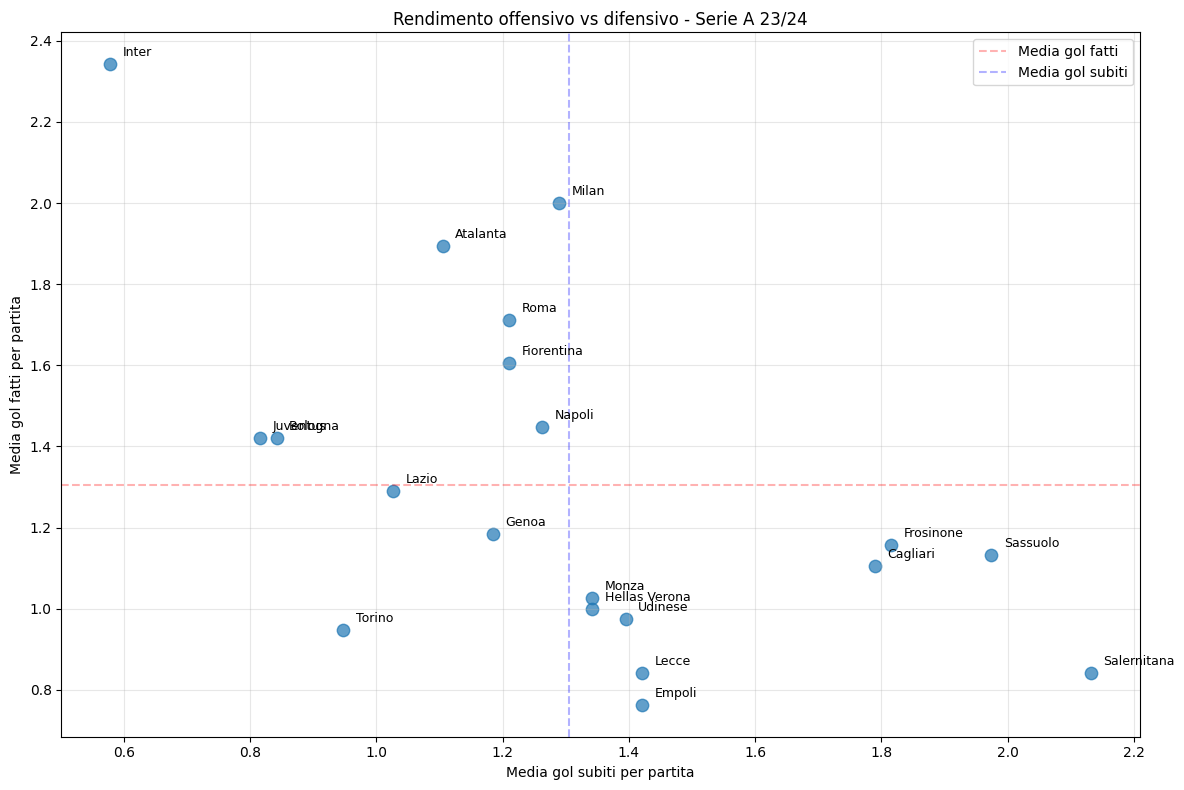

In [6]:
# Analisi offensiva e difensiva delle squadre direttamente dal DataFrame matches
# Dati per le squadre quando giocano in casa
home_stats = matches.groupby('Home Team').agg(
    gol_fatti_casa=('Score_casa', 'sum'),
    gol_subiti_casa=('Score_trasferta', 'sum'),
    partite_casa=('Round', 'count')
).reset_index()

# Dati per le squadre quando giocano in trasferta
away_stats = matches.groupby('Away Team').agg(
    gol_fatti_trasferta=('Score_trasferta', 'sum'),
    gol_subiti_trasferta=('Score_casa', 'sum'),
    partite_trasferta=('Round', 'count')
).reset_index()

# Unione dei due dataframe
team_stats = pd.merge(
    home_stats,
    away_stats,
    left_on='Home Team',
    right_on='Away Team',
    how='outer'
)

# Rinomina le colonne per chiarezza
team_stats = team_stats.rename(columns={'Home Team': 'name'})
team_stats.drop('Away Team', axis=1, inplace=True)

# Calcolo medie gol fatti e subiti
team_stats['Media_gol_fatti'] = (team_stats['gol_fatti_casa'] + team_stats['gol_fatti_trasferta']) / \
                               (team_stats['partite_casa'] + team_stats['partite_trasferta'])
team_stats['Media_gol_subiti'] = (team_stats['gol_subiti_casa'] + team_stats['gol_subiti_trasferta']) / \
                               (team_stats['partite_casa'] + team_stats['partite_trasferta'])

# Plottiamo un grafico a dispersione
plt.figure(figsize=(12, 8))
plt.scatter(team_stats['Media_gol_subiti'], team_stats['Media_gol_fatti'], s=80, alpha=0.7)

# Aggiungiamo i nomi delle squadre
for idx, row in team_stats.iterrows():
    plt.annotate(row['name'],
                 (row['Media_gol_subiti'] + 0.02, row['Media_gol_fatti'] + 0.02),
                 fontsize=9)

plt.axhline(y=team_stats['Media_gol_fatti'].mean(), color='r', linestyle='--', alpha=0.3, label='Media gol fatti')
plt.axvline(x=team_stats['Media_gol_subiti'].mean(), color='b', linestyle='--', alpha=0.3, label='Media gol subiti')

plt.xlabel('Media gol subiti per partita')
plt.ylabel('Media gol fatti per partita')
plt.title('Rendimento offensivo vs difensivo - Serie A 23/24')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Osservazioni principali:

- **Inter** è nettamente la squadra più completa: segna molto (oltre 2.3 gol a partita) e ha la miglior difesa del campionato.
- **Milan, Atalanta, Roma, Fiorentina** sono sopra media sia per attacco che per difesa: squadre solide e competitive.
- **Juventus** e **Bologna** hanno una delle migliori difese ma un attacco solo discreto.
- **Napoli** segna molto ma la sua fase difensiva è più fragile rispetto alle big.
- **Salernitana** è il fanalino di coda: pochi gol fatti e tantissimi subiti.
- **Torino** ha una buona difesa ma uno dei peggiori attacchi.
- **Cagliari, Sassuolo, Frosinone** sono tra le squadre che concedono di più, con attacchi sotto media.


## 3. Analisi del fattore campo

Il fattore campo è fondamentale nel calcio: il supporto del pubblico, la familiarità con il terreno e minori spostamenti possono contribuire significativamente ai risultati. Analizziamo quanto questo influenzi le squadre di Serie A.

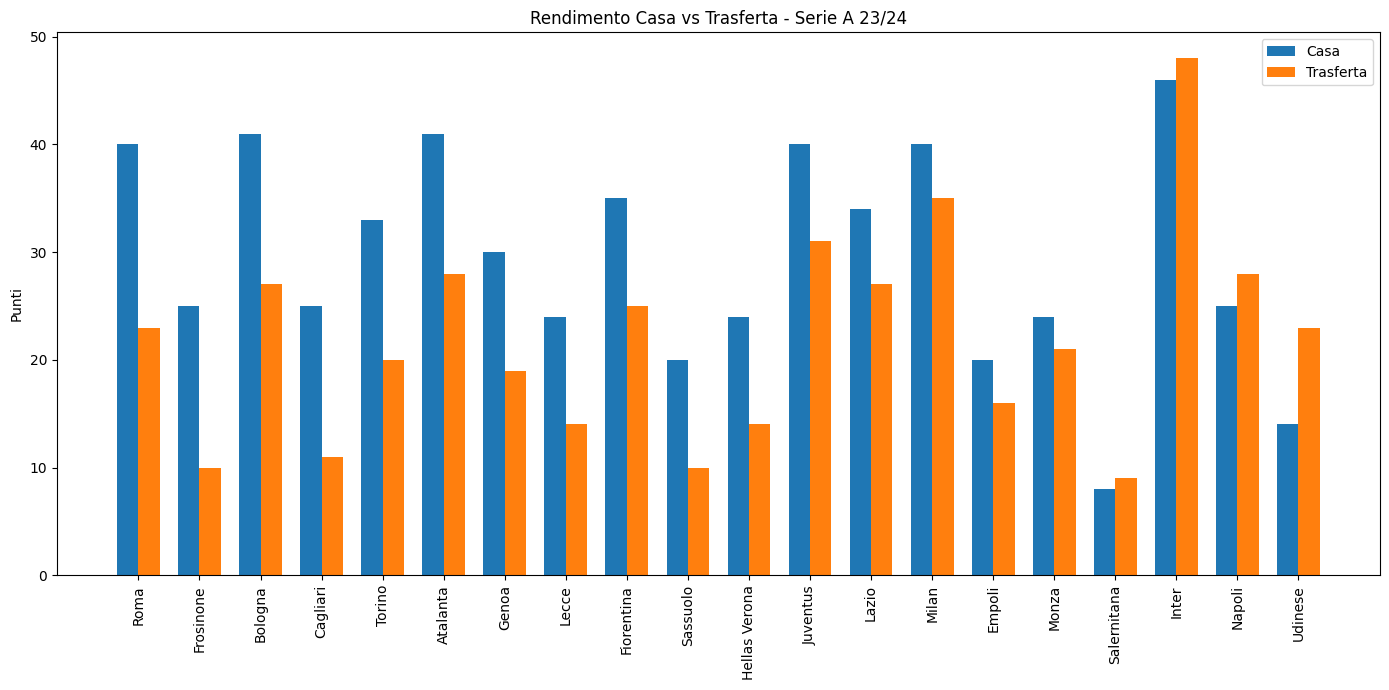

,name,points_home,points_away,points_diff
15,Roma,40,23,17
5,Frosinone,25,10,15
1,Bologna,41,27,14
2,Cagliari,25,11,14
18,Torino,33,20,13
0,Atalanta,41,28,13
6,Genoa,30,19,11
11,Lecce,24,14,10
4,Fiorentina,35,25,10
17,Sassuolo,20,10,10


In [7]:
# Analisi del rendimento casa vs trasferta usando solo il dataframe matches

# Aggreghiamo i dati per squadra di casa
home_performance = matches.groupby('Home Team').agg(
    partite_casa=('Round', 'count'),
    vittorie_casa=('Risultato', lambda x: (x == '1').sum()),
    pareggi_casa=('Risultato', lambda x: (x == 'X').sum()),
    sconfitte_casa=('Risultato', lambda x: (x == '2').sum()),
    gol_fatti_casa=('Score_casa', 'sum'),
    gol_subiti_casa=('Score_trasferta', 'sum'),
).reset_index()

# Aggreghiamo i dati per squadra in trasferta
away_performance = matches.groupby('Away Team').agg(
    partite_trasferta=('Round', 'count'),
    vittorie_trasferta=('Risultato', lambda x: (x == '2').sum()),
    pareggi_trasferta=('Risultato', lambda x: (x == 'X').sum()),
    sconfitte_trasferta=('Risultato', lambda x: (x == '1').sum()),
    gol_fatti_trasferta=('Score_trasferta', 'sum'),
    gol_subiti_trasferta=('Score_casa', 'sum'),
).reset_index()

# Uniamo i due dataframes
home_vs_away = pd.merge(
    home_performance,
    away_performance,
    left_on='Home Team',
    right_on='Away Team',
    suffixes=('', '_away')
)
home_vs_away = home_vs_away.rename(columns={'Home Team': 'name'})
home_vs_away.drop('Away Team', axis=1, inplace=True)

# Calcolo punti casa/trasferta (3 punti vittoria, 1 punto pareggio)
home_vs_away['points_home'] = home_vs_away['vittorie_casa'] * 3 + home_vs_away['pareggi_casa']
home_vs_away['points_away'] = home_vs_away['vittorie_trasferta'] * 3 + home_vs_away['pareggi_trasferta']

# Calcolo differenza punti
home_vs_away['points_diff'] = home_vs_away['points_home'] - home_vs_away['points_away']

# Ordinamento per chi ha più differenza casa/trasferta
home_vs_away_sorted = home_vs_away.sort_values('points_diff', ascending=False)

# Numero squadre
N = len(home_vs_away_sorted)
ind = np.arange(N)  # posizione X
width = 0.35  # larghezza barre

plt.figure(figsize=(14, 7))
plt.bar(ind, home_vs_away_sorted['points_home'], width, label='Casa')
plt.bar(ind + width, home_vs_away_sorted['points_away'], width, label='Trasferta')

plt.ylabel('Punti')
plt.title('Rendimento Casa vs Trasferta - Serie A 23/24')
plt.xticks(ind + width / 2, home_vs_away_sorted['name'], rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

# Mostra tabella riassuntiva
home_vs_away_sorted[['name', 'points_home', 'points_away', 'points_diff']]

### Interpretazione del fattore campo

Dal grafico possiamo osservare alcune tendenze significative:

- **Forte vantaggio casalingo**: Squadre come Roma, Bologna e Atalanta mostrano un netto vantaggio nelle partite casalinghe, ottenendo molti più punti in casa rispetto alla trasferta. Questo suggerisce una forte dipendenza dal supporto del pubblico e dalla familiarità con il proprio campo.

- **Equilibrio tra casa e trasferta**: Squadre come Inter, Milan e Juventus dimostrano maggiore continuità di rendimento, con punteggi simili sia in casa che in trasferta. Questa è una caratteristica tipica delle squadre di vertice, capaci di adattarsi tatticamente a contesti diversi.

- **Rendimento anomalo**: Le squadre che ottengono più punti in trasferta che in casa rappresentano casi particolari, spesso associati a uno stile di gioco basato sul contropiede o difficoltà ad esprimersi sotto la pressione del proprio pubblico.

Queste osservazioni saranno fondamentali per il nostro modello predittivo, evidenziando che il rendimento non è omogeneo tra casa e trasferta.

## 4. Distribuzione dei risultati nel campionato

Analizziamo la distribuzione dei vari tipi di risultato (vittoria casa, pareggio, vittoria trasferta) per comprendere le tendenze generali del campionato e la base probabilistica di ciascun esito.

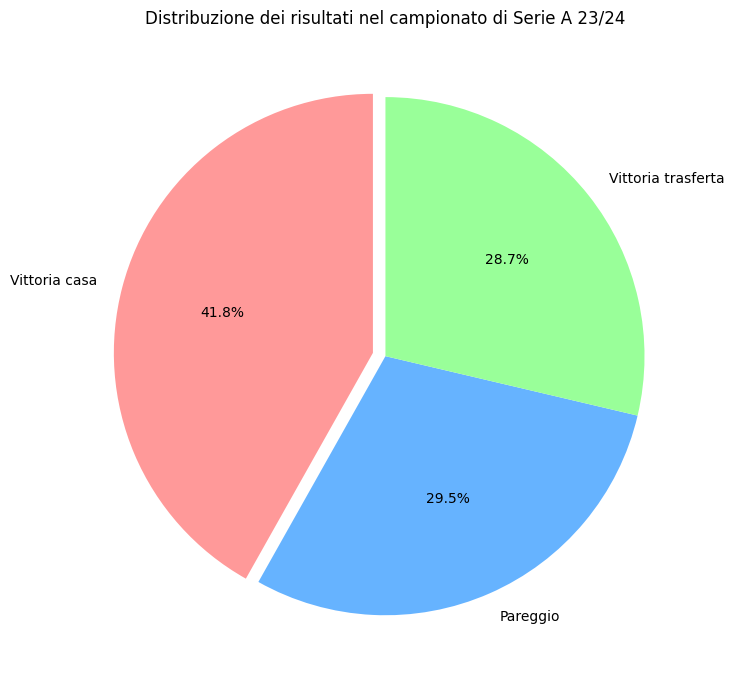

Vittorie in casa: 159 (41.8%)
Pareggi: 112 (29.5%)
Vittorie in trasferta: 109 (28.7%)


In [8]:
# Analizziamo la distribuzione dei risultati (1, X, 2)
risultati_count = matches['Risultato'].value_counts()

# Creiamo un grafico a torta
plt.figure(figsize=(10, 7))
plt.pie(risultati_count, labels=['Vittoria casa', 'Pareggio', 'Vittoria trasferta'] if len(risultati_count) == 3 else risultati_count.index, 
        autopct='%1.1f%%', startangle=90, explode=[0.05, 0, 0] if len(risultati_count) == 3 else None,
        colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribuzione dei risultati nel campionato di Serie A 23/24')
plt.tight_layout()
plt.show()

print(f"Vittorie in casa: {risultati_count.get('1', 0)} ({risultati_count.get('1', 0)/len(matches)*100:.1f}%)")
print(f"Pareggi: {risultati_count.get('X', 0)} ({risultati_count.get('X', 0)/len(matches)*100:.1f}%)")
print(f"Vittorie in trasferta: {risultati_count.get('2', 0)} ({risultati_count.get('2', 0)/len(matches)*100:.1f}%)")

### Analisi statistica del fattore campo

Possiamo formulare un'ipotesi formale sul fattore campo: 

- **H0** (ipotesi nulla): Non c'è differenza significativa tra la probabilità di vittoria in casa e la probabilità di vittoria in trasferta
- **H1** (ipotesi alternativa): La probabilità di vittoria in casa è significativamente maggiore della probabilità di vittoria in trasferta

Verifichiamo questa ipotesi utilizzando un test statistico.

In [9]:
# Estrazione dei dati necessari per il test
home_scored = matches['Score_casa'].mean()
away_scored = matches['Score_trasferta'].mean()

# Eseguiamo un t-test per confrontare le medie dei gol fatti in casa vs trasferta
t_stat_scored, p_value_scored = stats.ttest_ind_from_stats(
    mean1=home_scored, std1=matches['Score_casa'].std(), nobs1=len(matches),
    mean2=away_scored, std2=matches['Score_trasferta'].std(), nobs2=len(matches),
    equal_var=False
)

alpha = 0.05
home_advantage_goals = home_scored - away_scored

print(f"Test sull'ipotesi: i gol segnati in casa sono più di quelli in trasferta")
print(f"Media gol segnati in casa: {home_scored:.2f}")
print(f"Media gol segnati in trasferta: {away_scored:.2f}")
print(f"t-statistic: {t_stat_scored:.4f}")
print(f"p-value: {p_value_scored:.4f}")

Test sull'ipotesi: i gol segnati in casa sono più di quelli in trasferta
Media gol segnati in casa: 1.43
Media gol segnati in trasferta: 1.18
t-statistic: 3.0788
p-value: 0.0022


Interpretazione sull'ipotesi: i gol segnati in casa sono più di quelli in trasferta.


Il p-value (0.0015) è inferiore al livello di significatività (0.05), quindi respingiamo l'ipotesi nulla.
C'è evidenza statistica che le squadre segnano più gol quando giocano in casa rispetto a quando giocano in trasferta.

Vantaggio del fattore campo: in media, le squadre segnano 0.26 gol in più per partita quando giocano in casa rispetto alla trasferta.

Possiamo quindi concludere che il fattore campo ha un impatto significativo sui risultati delle partite di Serie A. Le squadre tendono a segnare più gol e subire meno quando giocano in casa.

## 5. Modello di Predizione basato su Media Gol

Svilupperemo un modello che predice i risultati delle ultime 5 giornate basandosi sulla media dei gol segnati e subiti dalle squadre, considerando separatamente le performance in casa e in trasferta.

In [10]:
def calculate_team_stats(train_df):
    """
    Calcola le statistiche per ogni squadra basandosi sulle prime 32 giornate.
    
    Args:
        matches: DataFrame con tutti i dati delle partite
        
    Returns:
        Dictionary con le statistiche per ogni squadra
    """
    
    # Calcolo delle statistiche per ogni squadra
    teams = pd.unique(train_df[['Home Team', 'Away Team']].values.ravel())
    team_stats = {} 
    
    for team in teams:
        # Filtra le partite in casa e in trasferta per questa squadra
        home_matches = train_df[train_df['Home Team'] == team]
        away_matches = train_df[train_df['Away Team'] == team]
        
        # Calcola le medie dei gol (evita divisione per zero)
        avg_home_scored = home_matches['Score_casa'].mean() if len(home_matches) > 0 else 0
        avg_home_conceded = home_matches['Score_trasferta'].mean() if len(home_matches) > 0 else 0
        avg_away_scored = away_matches['Score_trasferta'].mean() if len(away_matches) > 0 else 0
        avg_away_conceded = away_matches['Score_casa'].mean() if len(away_matches) > 0 else 0
        
        team_stats[team] = {
            'avg_home_scored': avg_home_scored,
            'avg_home_conceded': avg_home_conceded,
            'avg_away_scored': avg_away_scored,
            'avg_away_conceded': avg_away_conceded,
        }
    
    return team_stats

team_stats = calculate_team_stats(matches[matches["Round"] < 33].copy())


Il dataset è stato suddiviso in due parti:

Train_mathces: Contiene le partite delle prime 33 giornate.
Test_matches: Contiene le partite delle ultime 5 giornate.

È stato creato un modello pipeline che include:

StandardScaler: Per normalizzare i dati.
LogisticRegression: Per predire i risultati delle partite.




In [11]:
# Split in training (prime 34 giornate) e test (ultime 5 giornate)
train_matches = matches[matches['Round'] < 34]
test_matches = matches[matches['Round'] >= 34]

# Funzione per estrarre le features con gestione errori
def extract_features(row):
    home_team = row['Home Team']
    away_team = row['Away Team']

    home_stats = team_stats[home_team]
    away_stats = team_stats[away_team]
    
    return [
        home_stats['avg_home_scored'],
        home_stats['avg_home_conceded'],
        away_stats['avg_away_scored'],
        away_stats['avg_away_conceded'],
    ]

# Prepara i dati di training
X_train = np.array(train_matches.apply(extract_features, axis=1).tolist())
y_train = train_matches['Risultato'].replace({'X': '0', '1': '1', '2': '2'}).astype(int)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}


# Crea e allena il modello con parametri ottimizzati
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        class_weight=class_weight_dict,
        C=0.5,
    )
)
model.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.5,
                                    class_weight={0: np.float64(1.1956521739130435),
                                                  1: np.float64(0.7857142857142857),
                                                  2: np.float64(1.1224489795918366)},
                                    max_iter=1000, random_state=42))])

Predizione dei Risultati

In questa sezione, utilizziamo il modello addestrato per effettuare predizioni sui dati di test (le ultime 5 giornate del campionato). Di seguito sono riportati i passaggi principali:

1. **Preparazione dei dati di test**:
   - Le caratteristiche delle partite di test vengono estratte utilizzando la funzione `extract_features`.
   - I risultati reali delle partite vengono convertiti in formato numerico per il confronto con le predizioni.

2. **Generazione delle predizioni**:
   - Il modello predice i risultati delle partite in formato numerico.
   - Viene calcolata anche la probabilità associata a ciascun possibile risultato (vittoria in casa, pareggio, vittoria in trasferta).

3. **Calcolo dell'accuratezza**:
   - L'accuratezza del modello viene calcolata confrontando le predizioni con i risultati reali.

4. **Creazione del DataFrame finale**:
   - Viene creato un DataFrame che include:
     - I risultati reali delle partite.
     - Le predizioni del modello.
     - Un'indicazione se la predizione è corretta o meno.
     - Le probabilità associate a ciascun possibile risultato.

Questo processo consente di analizzare le prestazioni del modello e di valutare la sua capacità di predire correttamente i risultati delle partite.

In [12]:
# Prepara i dati di test
X_test = np.array(test_matches.apply(extract_features, axis=1).tolist())
y_test = test_matches['Risultato'].replace({'X': '0', '1': '1', '2': '2'}).astype(int)

# Genera predizioni numeriche
numeric_predictions = model.predict(X_test)
prediction_probs = model.predict_proba(X_test)

# Calcola l'accuratezza
accuracy = accuracy_score(y_test, numeric_predictions)

# Crea DataFrame con i risultati delle predizioni
final_predictions = test_matches.copy()
final_predictions['Prediction'] = pd.Series(numeric_predictions).map({0: 'X', 1: '1', 2: '2'}).values
final_predictions['Correct'] = final_predictions['Risultato'] == final_predictions['Prediction']

# Aggiungi probabilità per ogni possibile risultato
final_predictions['Prob_1'] = prediction_probs[:, 1] 
final_predictions['Prob_X'] = prediction_probs[:, 0]
final_predictions['Prob_2'] = prediction_probs[:, 2]

Analisi delle predizioni

In [13]:
print(f"\nAccuratezza sulle ultime {len(test_matches)//10} giornate: {accuracy * 100:.1f}%")
print(f"Partite corrette: {final_predictions['Correct'].sum()}/{len(final_predictions)}")

# Report di classificazione completo
print("\nReport di classificazione:")
print(classification_report(
    y_test, 
    numeric_predictions,
    target_names=['Pareggio (X)', 'Vittoria Casa (1)', 'Vittoria Trasferta (2)']
))

# Visualizziamo il riassunto dei risultati per giornata
results_by_round = final_predictions.groupby('Round')['Correct'].mean()
print("Accuratezza per giornata:")
print(results_by_round)

final_predictions


Accuratezza sulle ultime 5 giornate: 50.0%
Partite corrette: 25/50

Report di classificazione:
                        precision    recall  f1-score   support

          Pareggio (X)       0.46      0.30      0.36        20
     Vittoria Casa (1)       0.59      0.68      0.63        19
Vittoria Trasferta (2)       0.40      0.55      0.46        11

              accuracy                           0.50        50
             macro avg       0.48      0.51      0.49        50
          weighted avg       0.50      0.50      0.49        50

Accuratezza per giornata:
Round
34    0.6
35    0.4
36    0.7
37    0.4
38    0.4
Name: Correct, dtype: float64


,Round,Home Team,Away Team,Score_casa,Score_trasferta,Risultato,Prediction,Correct,Prob_1,Prob_X,Prob_2
330,34,Frosinone,Salernitana,3,0,1,1,True,0.545057,0.352007,0.102936
331,34,Lecce,Monza,1,1,X,X,True,0.194482,0.475300,0.330218
332,34,Juventus,Milan,0,0,X,2,False,0.349630,0.288226,0.362144
333,34,Lazio,Hellas Verona,1,0,1,X,False,0.422870,0.442918,0.134212
334,34,Inter,Torino,2,0,1,1,True,0.739784,0.196219,0.063997
335,34,Bologna,Udinese,1,1,X,1,False,0.673161,0.272758,0.054081
336,34,Napoli,Roma,2,2,X,2,False,0.165505,0.334824,0.499671
337,34,Atalanta,Empoli,2,0,1,1,True,0.705092,0.230196,0.064712
338,34,Fiorentina,Sassuolo,5,1,1,1,True,0.622052,0.282582,0.095365
339,34,Genoa,Cagliari,3,0,1,1,True,0.432088,0.426089,0.141823


Abbiamo osservato che, quando le probabilità degli eventi 1, X o 2 sono simili tra loro, il modello tende a commettere più errori nelle predizioni.


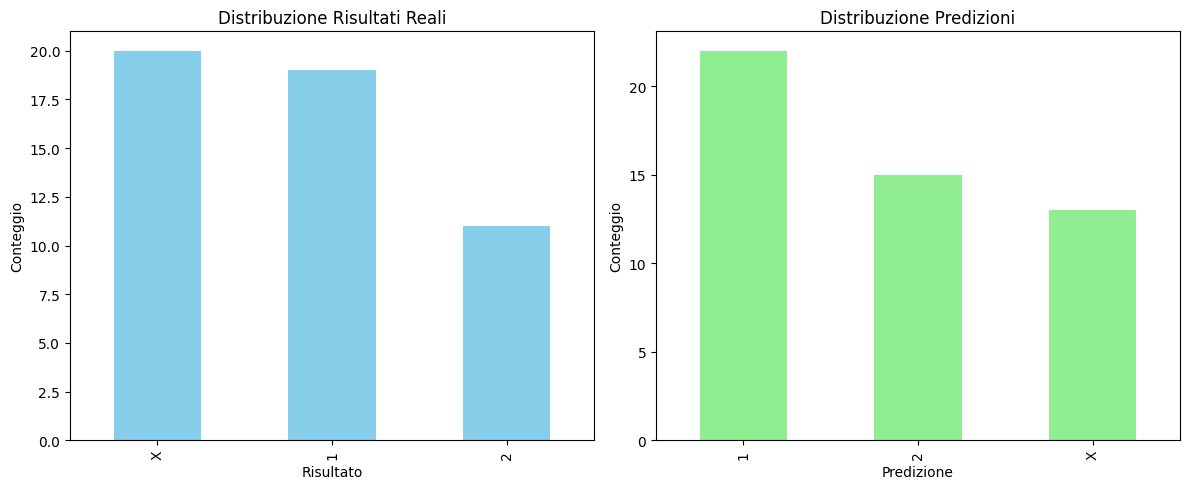

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
final_predictions['Risultato'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribuzione Risultati Reali')
plt.xlabel('Risultato')
plt.ylabel('Conteggio')

plt.subplot(1, 2, 2)
final_predictions['Prediction'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribuzione Predizioni')
plt.xlabel('Predizione')
plt.ylabel('Conteggio')

plt.tight_layout()
plt.show()



Il modello sembra prediligere le vittorie in casa (1) rispetto agli altri risultati, con una frequenza maggiore di predizioni per questo esito.
I pareggi (X) e le vittorie in trasferta (2) sono predetti meno frequentemente rispetto alla loro presenza nei risultati reali.

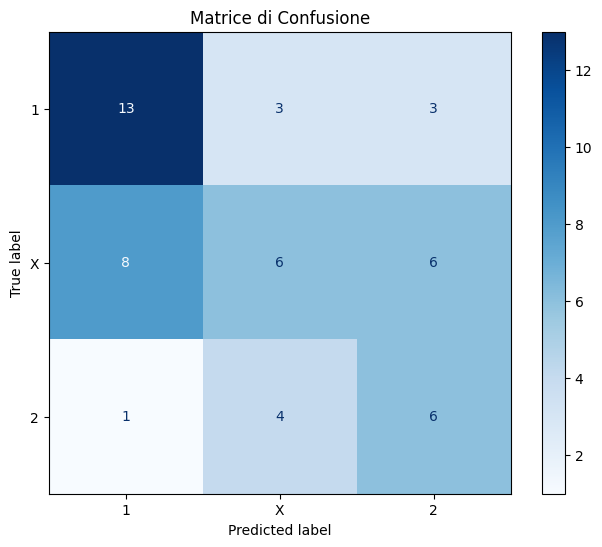

Matrice di Confusione:
[[13  3  3]
 [ 8  6  6]
 [ 1  4  6]]


In [15]:
# Calcola la matrice di confusione
cm = confusion_matrix(final_predictions['Risultato'], final_predictions['Prediction'], labels=['1', 'X', '2'])

# Visualizza la matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['1', 'X', '2'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Matrice di Confusione')
plt.show()

print("Matrice di Confusione:")
print(cm)

Prestazioni del modello per ciascuna classe:

Vittorie in casa (1):

Il modello ha predetto correttamente 13 vittorie in casa.
Ha confuso 3 vittorie in casa con pareggi (X) e altre 3 con vittorie in trasferta (2).
Questo indica che il modello è relativamente affidabile nel predire vittorie in casa, ma non perfetto.

Pareggi (X):
Solo 6 pareggi sono stati predetti correttamente.
Il modello ha confuso 8 pareggi con vittorie in casa (1) e 6 con vittorie in trasferta (2).
Questo suggerisce che il modello fatica a distinguere i pareggi dagli altri risultati.

Vittorie in trasferta (2):
Il modello ha predetto correttamente 6 vittorie in trasferta.
Ha confuso 1 vittoria in trasferta con una vittoria in casa (1) e 4 con pareggi (X).
Anche qui, il modello mostra difficoltà nel riconoscere correttamente le vittorie in trasferta.


